In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from sklearn.model_selection import cross_val_score, KFold
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler


In [223]:
# 1. Đọc dữ liệu từ file CSV
df = pd.read_csv("Gold Price (2013-2023).csv")

In [224]:
print(df.dtypes)


Date        object
Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object


In [225]:


# Bước 1: Chuyển đổi cột 'Date' thành datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Bước 2: Loại bỏ dấu phẩy và chuyển đổi các cột về kiểu float
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].replace({',': ''}, regex=True).astype(float)

# Bước 3: Xử lý cột 'Vol.' để chuyển đổi giá trị có ký hiệu 'K' thành số thực
df['Vol.'] = df['Vol.'].replace({',': ''}, regex=True)
df['Vol.'] = df['Vol.'].apply(lambda x: float(x.replace('K', '')) * 1000 if 'K' in str(x) else float(x))

# Bước 4: Loại bỏ dấu phần trăm trong cột 'Change %' và chuyển đổi về kiểu float
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)

# Kiểm tra lại kết quả
print(df.dtypes)
print(df.head())


Date        datetime64[ns]
Price              float64
Open               float64
High               float64
Low                float64
Vol.               float64
Change %           float64
dtype: object
        Date   Price    Open     High      Low      Vol.  Change %
0 2022-12-30  1826.2  1821.8  1832.40  1819.80  107500.0      0.01
1 2022-12-29  1826.0  1812.3  1827.30  1811.20  105990.0      0.56
2 2022-12-28  1815.8  1822.4  1822.80  1804.20  118080.0     -0.40
3 2022-12-27  1823.1  1808.2  1841.90  1808.00  159620.0      0.74
4 2022-12-26  1809.7  1805.8  1811.95  1805.55       NaN      0.30


In [226]:
# # Xóa dấu phân cách hàng nghìn và chuyển đổi sang kiểu float trước khi đổi sang int64
# for col in df.select_dtypes(include=['object']).columns:
#     # Loại bỏ dấu phẩy nếu có trong dữ liệu và chuyển sang float
#     df[col] = df[col].str.replace(',','').astype(float)

# # Sau khi tất cả các cột đã được chuyển về dạng float, chuyển sang int64 nếu cần
# for col in df.columns:
#     if df[col].dtype == 'float64':
#         df[col] = df[col].astype('int64')

# # Kiểm tra lại kiểu dữ liệu và hiển thị dữ liệu đầu ra
# print(df.dtypes)
# print(df.head())


In [227]:
# Đầu tiên chuyển các cột dữ liệu về dạng số nếu có giá trị chuỗi
df = df.apply(pd.to_numeric, errors='coerce')

# Đổi các cột dạng float64 thành int64
for col in df.select_dtypes(include=['float64', 'int32']).columns:
    df[col] = df[col].fillna(0).astype('int64')  # Điền giá trị thiếu (nếu có) và đổi kiểu

# Kiểm tra lại kiểu dữ liệu
print(df.dtypes)


Date        int64
Price       int64
Open        int64
High        int64
Low         int64
Vol.        int64
Change %    int64
dtype: object


In [228]:
# Hiển thị thông tin tổng quan về dữ liệu
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Date      2583 non-null   int64
 1   Price     2583 non-null   int64
 2   Open      2583 non-null   int64
 3   High      2583 non-null   int64
 4   Low       2583 non-null   int64
 5   Vol.      2583 non-null   int64
 6   Change %  2583 non-null   int64
dtypes: int64(7)
memory usage: 141.4 KB
None


In [229]:
df.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

In [230]:
def compare_predictions(y_test, y_pred, model_name):
    comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    print(f"\nComparison for {model_name} model:")
    print(comparison.head())  # Hiển thị 5 giá trị đầu tiên

In [231]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,1672358400000000000,1826,1821,1832,1819,107500,0
1,1672272000000000000,1826,1812,1827,1811,105990,0
2,1672185600000000000,1815,1822,1822,1804,118080,0
3,1672099200000000000,1823,1808,1841,1808,159620,0
4,1672012800000000000,1809,1805,1811,1805,0,0


# TIỀN XỬ LÍ DỮ LIỆU

In [232]:
#Vì chúng tôi sẽ không sử dụng Vol. và Thay đổi tính năng % để dự đoán Giá, chúng tôi sẽ bỏ hai tính năng này
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)

In [233]:

# Chuyển đổi cột "date" sang kiểu datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  

# Tách các đặc trưng số từ cột "date"
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['day_of_week'] = df['Date'].dt.dayofweek
df['day_of_year'] = df['Date'].dt.dayofyear

# Xóa cột "date" gốc vì không cần thiết cho mô hình
df = df.drop(columns=['Date'])

# Đảm bảo không có giá trị null (do lỗi chuyển đổi date) và mọi cột đều là số
df = df.dropna()

# Xử lý dữ liệu cho mô hình
X = df.drop(columns=['Price'])  # 'target_column' là cột đích bạn muốn dự đoán
y = df['Price']


In [234]:
X = df.drop(columns=['Price'])  # Loại bỏ cột 'Price' và 'Date' nếu không sử dụng cột Date
y = df['Price']  # Cột mục tiêu

In [235]:
X.head()


,Open,High,Low,year,month,day,day_of_week,day_of_year
0,1821,1832,1819,2022,12,30,4,364
1,1812,1827,1811,2022,12,29,3,363
2,1822,1822,1804,2022,12,28,2,362
3,1808,1841,1808,2022,12,27,1,361
4,1805,1811,1805,2022,12,26,0,360


In [236]:
y.head()

0    1826
1    1826
2    1815
3    1823
4    1809
Name: Price, dtype: int64

In [237]:
# # Giả sử bạn có một cột chứa các giá trị dạng chuỗi
# df['Price'] = df['Price'].str.replace(',', '')  # Loại bỏ dấu phẩy
# df['Price'] = df['Price'].astype(float)  # Chuyển đổi thành float



In [238]:
# # Giả sử bạn có một cột chứa các giá trị dạng chuỗi
# df['High'] = df['High'].str.replace(',', '')  # Loại bỏ dấu phẩy
# df['High'] = df['High'].astype(float)  # Chuyển đổi thành float

In [239]:
X.head()


,Open,High,Low,year,month,day,day_of_week,day_of_year
0,1821,1832,1819,2022,12,30,4,364
1,1812,1827,1811,2022,12,29,3,363
2,1822,1822,1804,2022,12,28,2,362
3,1808,1841,1808,2022,12,27,1,361
4,1805,1811,1805,2022,12,26,0,360


In [240]:
# # Giả sử bạn có một cột chứa các giá trị dạng chuỗi
# df['Low'] = df['Low'].str.replace(',', '')  # Loại bỏ dấu phẩy
# df['Low'] = df['Low'].astype(float)  # Chuyển đổi thành float

In [241]:
# Lấy kích thước của DataFrame cho năm 2022
test_size = df[df['year'] == 2022].shape[0]
print(test_size)


260


In [242]:
window_size = 60


In [243]:
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1,1))

MinMaxScaler()

In [244]:
train_data = df.Price[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [245]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [246]:
test_data = df.Price[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [247]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

In [248]:
# 3. Chia dữ liệu thành tập huấn luyện và kiểm thử (70% huấn luyện, 30% kiểm thử)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [249]:
# # Chuyển đổi y_train
# y_train = y_train.str.replace(',', '').astype(float)


In [250]:
# Kiểm tra các giá trị trong cột Open để xác định lỗi
print(df['Open'].head(10))  # Kiểm tra thử 10 dòng đầu tiên để xem cấu trúc dữ liệu

# Xóa dấu phẩy và chuyển đổi sang float
df['Open'] = df['Open'].replace(',', '', regex=True)  # Xóa dấu phẩy trong chuỗi

# Kiểm tra lại kiểu dữ liệu sau khi chuyển đổi
df['Open'] = pd.to_numeric(df['Open'], errors='coerce')  # Chuyển đổi dữ liệu về dạng số
print(df.dtypes)  # Xác nhận kiểu dữ liệu



0    1821
1    1812
2    1822
3    1808
4    1805
5    1801
6    1823
7    1827
8    1796
9    1801
Name: Open, dtype: int64
Price          int64
Open           int64
High           int64
Low            int64
year           int32
month          int32
day            int32
day_of_week    int32
day_of_year    int32
dtype: object


In [251]:
print(df.dtypes)


Price          int64
Open           int64
High           int64
Low            int64
year           int32
month          int32
day            int32
day_of_week    int32
day_of_year    int32
dtype: object


# HỒI QUY TUYẾN TÍNH

In [252]:
# 4. Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
compare_predictions(y_test, y_pred_lr, "Linear Regression")


Comparison for Linear Regression model:
     Actual  Predicted
0  0.188305   0.180901
1  0.174430   0.190786
2  0.151635   0.173107
3  0.153617   0.153286
4  0.163528   0.154835


In [253]:

# Dự đoán trên tập kiểm tra
y_pred_lr = model_lr.predict(X_test)
mae_linear = mean_absolute_error(y_test, y_pred_lr)
rmse_linear = math.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_linear = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - MAE: {mae_linear}, RMSE: {rmse_linear}, R2: {r2_linear}")

Linear Regression - MAE: 0.013112522568392912, RMSE: 0.0192673631507468, R2: 0.9826665618312451


In [256]:
# plt.scatter(y_test, y_pred_lr, label="Linear Regression")
# plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linewidth=2, label="Actual")
# plt.xlabel("Giá thực tế")
# plt.ylabel("Giá dự đoán")
# plt.legend()
# plt.title("Biểu đồ giữa dự đoán và thực tế của mô hình")
# plt.show()


# Rigde


In [257]:

# Khởi tạo và huấn luyện Ridge Regression
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)

y_pred_ridge = ridge_reg.predict(X_test)

# Đánh giá mô hình Ridge Regression
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = math.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Ridge Regression - MAE: {mae_ridge}, RMSE: {rmse_ridge}, R2: {r2_ridge}")


Ridge Regression - MAE: 0.016120411816787365, RMSE: 0.022684622091273487, R2: 0.9759727953852294


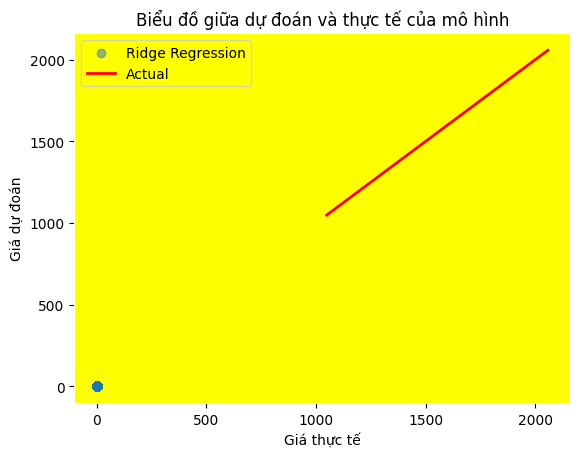

In [258]:
plt.scatter(y_test, y_pred_ridge, label="Ridge Regression", alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linewidth=2, label="Actual")
plt.xlabel("Giá thực tế")
plt.ylabel("Giá dự đoán")
plt.legend()
plt.title("Biểu đồ giữa dự đoán và thực tế của mô hình")
plt.show()

# Neural network

In [259]:
# 6. Neural Network (MLPRegressor)
model_nn = MLPRegressor(hidden_layer_sizes=(100, 50),activation='relu', max_iter=500)
model_nn.fit(X_train, y_train)
y_pred_nn = model_nn.predict(X_test)
compare_predictions(y_test, y_pred_nn, "Neural Network")


Comparison for Neural Network model:
     Actual  Predicted
0  0.188305   0.172982
1  0.174430   0.180129
2  0.151635   0.175086
3  0.153617   0.169177
4  0.163528   0.157548


In [260]:
# Đánh giá mô hình Neural Network
mae_nn = mean_absolute_error(y_test, y_pred_nn)
rmse_nn = math.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)

print(f"Neural Network - MAE: {mae_nn}, RMSE: {rmse_nn}, R2: {r2_nn}")

Neural Network - MAE: 0.026258052654038914, RMSE: 0.034252634600375115, R2: 0.9452192324755824


In [263]:
# Đánh giá mô hình Neural Network
mae_nn = mean_absolute_error(y_test, y_pred_nn)
rmse_nn = math.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)

print(f"Neural Network - MAE: {mae_nn}, RMSE: {rmse_nn}, R2: {r2_nn}")

Neural Network - MAE: 0.026258052654038914, RMSE: 0.034252634600375115, R2: 0.9452192324755824


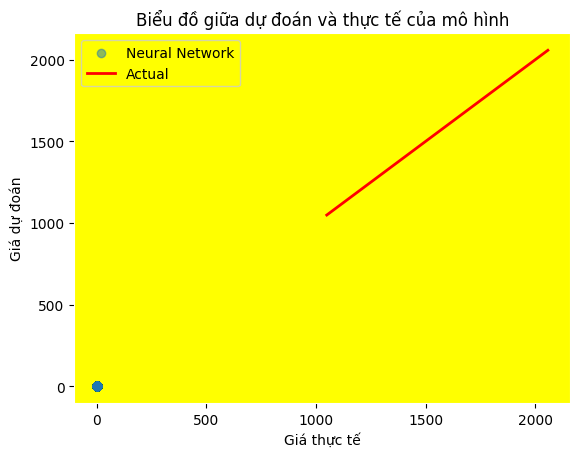

In [264]:
plt.scatter(y_test, y_pred_nn, label="Neural Network", alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linewidth=2, label="Actual")
plt.xlabel("Giá thực tế")
plt.ylabel("Giá dự đoán")
plt.legend()
plt.title("Biểu đồ giữa dự đoán và thực tế của mô hình")
plt.show()

In [265]:
# Sử dụng 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# K-Fold cho Linear Regression
cv_r2_scores_linear = cross_val_score(model_lr, X_train, y_train, cv=kf, scoring='r2')
print(f"Linear Regression R^2 scores (K-Fold): {cv_r2_scores_linear}")
print(f"Mean R^2 on training set for Linear Regression: {np.mean(cv_r2_scores_linear)}")

# K-Fold cho Ridge Regression
cv_r2_scores_ridge = cross_val_score(ridge_reg, X_train, y_train, cv=kf, scoring='r2')
print(f"Ridge Regression R^2 scores (K-Fold): {cv_r2_scores_ridge}")
print(f"Mean R^2 on training set for Ridge Regression: {np.mean(cv_r2_scores_ridge)}")

# K-Fold cho Neural Network (MLPRegressor)
cv_r2_scores_nn = cross_val_score(model_nn, X_train, y_train, cv=kf, scoring='r2')
print(f"Neural Network R^2 scores (K-Fold): {cv_r2_scores_nn}")
print(f"Mean R^2 on training set for Neural Network: {np.mean(cv_r2_scores_nn)}")

# So sánh kết quả R² trên tập kiểm tra và tập huấn luyện
ridge_reg.fit(X_train, y_train)
y_pred_ridge = ridge_reg.predict(X_test)
r2_test_ridge = r2_score(y_test, y_pred_ridge)
print(f"R^2 on test set for Ridge Regression: {r2_test_ridge}")

model_lr.fit(X_train, y_train)
y_pred_linear = model_lr.predict(X_test)
r2_test_linear = r2_score(y_test, y_pred_linear)
print(f"R^2 on test set for Linear Regression: {r2_test_linear}")

model_nn.fit(X_train, y_train)
y_pred_nn = model_nn.predict(X_test)
r2_test_nn = r2_score(y_test, y_pred_nn)
print(f"R^2 on test set for Neural Network: {r2_test_nn}")

# Kiểm tra overfitting
if r2_test_ridge < np.mean(cv_r2_scores_ridge) - 0.1:
    print("Ridge model: Possible overfitting detected")
else:
    print("Ridge model: No overfitting detected")

if r2_test_linear < np.mean(cv_r2_scores_linear) - 0.1:
    print("Linear model: Possible overfitting detected")
else:
    print("Linear model: No overfitting detected")

if r2_test_nn < np.mean(cv_r2_scores_nn) - 0.1:
    print("Neural Network model: Possible overfitting detected")
else:
    print("Neural Network model: No overfitting detected")

Linear Regression R^2 scores (K-Fold): [0.99780832 0.99749842 0.99686198 0.99671906 0.99662805]
Mean R^2 on training set for Linear Regression: 0.9971031667270565
Ridge Regression R^2 scores (K-Fold): [0.99664348 0.99643768 0.99552222 0.99563758 0.99577793]
Mean R^2 on training set for Ridge Regression: 0.996003775888299
Neural Network R^2 scores (K-Fold): [0.99294432 0.98700589 0.98770334 0.9881471  0.97676233]
Mean R^2 on training set for Neural Network: 0.9865125970628421
R^2 on test set for Ridge Regression: 0.9759727953852294
R^2 on test set for Linear Regression: 0.9826665618312451
R^2 on test set for Neural Network: 0.9351411062901991
Ridge model: No overfitting detected
Linear model: No overfitting detected
Neural Network model: No overfitting detected


In [266]:
# 7. Stacking Model
estimators = [
    ('lr', LinearRegression()),
    ('ridge', Ridge(alpha=1.0)),
    ('nn', MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500))
]
stacking_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)
compare_predictions(y_test, y_pred_stack, "Stacking")


Comparison for Stacking model:
     Actual  Predicted
0  0.188305   0.180896
1  0.174430   0.189746
2  0.151635   0.172182
3  0.153617   0.153126
4  0.163528   0.154645


In [267]:
# Đánh giá mô hình Stacking
mae_stack = mean_absolute_error(y_test, y_pred_stack)
rmse_stack = math.sqrt(mean_squared_error(y_test, y_pred_stack))
r2_stack = r2_score(y_test, y_pred_stack)

print(f"Stacking Model - MAE: {mae_stack}, RMSE: {rmse_stack}, R²: {r2_stack}")


Stacking Model - MAE: 0.013132504956467832, RMSE: 0.019254033220078907, R²: 0.9826905374631147


In [268]:
# K-Fold Cross-Validation cho Stacking Model
cv_r2_scores_stack = cross_val_score(stacking_model, X_train, y_train, cv=kf, scoring='r2')
print(f"Stacking Model R² scores (K-Fold): {cv_r2_scores_stack}")
print(f"Mean R² on training set for Stacking Model: {np.mean(cv_r2_scores_stack)}")


Stacking Model R² scores (K-Fold): [0.99779188 0.99748583 0.99683423 0.99669055 0.99665616]
Mean R² on training set for Stacking Model: 0.9970917291239652


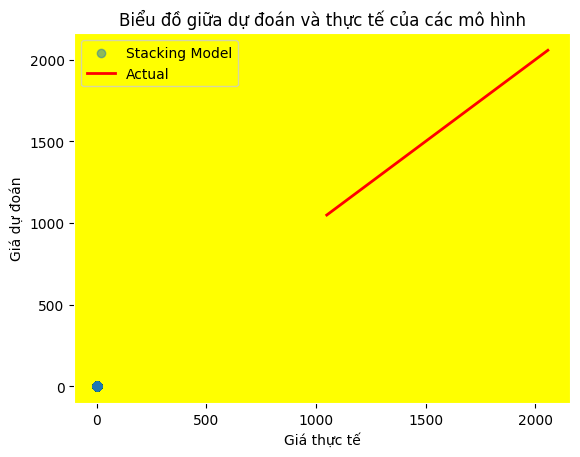

In [269]:
plt.scatter(y_test, y_pred_stack, label="Stacking Model", alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linewidth=2, label="Actual")
plt.xlabel("Giá thực tế")
plt.ylabel("Giá dự đoán")
plt.legend()
plt.title("Biểu đồ giữa dự đoán và thực tế của các mô hình")
plt.show()


In [25]:
# 8. Đánh giá mô hình bằng các chỉ số như MSE, MAE, R²
def evaluate_model(y_test, y_pred, model_name):
    print(f"\n{model_name} Model Evaluation:")
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("R²:", r2_score(y_test, y_pred))
    
    

# Đánh giá từng mô hình
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_ridge, "Ridge Regression")
evaluate_model(y_test, y_pred_nn, "Neural Network")
evaluate_model(y_test, y_pred_stack, "Stacking")


Linear Regression Model Evaluation:
MSE: 8916.032070651745
MAE: 62.84603297789227
R²: 0.9998930081441777

Ridge Regression Model Evaluation:
MSE: 8917.499040226705
MAE: 62.8440479546778
R²: 0.9998929905406297

Neural Network Model Evaluation:
MSE: 50922.005148799384
MAE: 137.84623770578344
R²: 0.9993889389596299

Stacking Model Evaluation:
MSE: 9011.100644111282
MAE: 62.91415605197466
R²: 0.9998918673269369
